In [1]:
# from numpy.core.defchararray import index
# from sequence_readout import get_intensity_df
# from sequence_readout import get_seq_df
# from sequence_readout import tophat_spots
# from reference_check import check_sequence
# from mapping import map_barcode
# from mapping import unstack_plex
import os
import sys
from datetime import datetime
from tqdm import tqdm
from tqdm import trange
import numpy as np
from skimage.io import imread
from skimage.io import imsave
import pandas as pd
from pathlib import Path
import seaborn as sns
from tqdm import tqdm
import yaml
import cv2
import matplotlib
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
# from draw_spots import crop_df
# import scanpy as sc

In [2]:
BASE_DIR = Path(r"F:\spatial_data\processed")
RUN_ID = '20240428_PRISM30_TNBC_BZ02_CA2'
src_dir = BASE_DIR / f'{RUN_ID}_processed'
stc_dir = src_dir / 'stitched'
read_dir = src_dir / 'readout'
read_dir.mkdir(exist_ok=True)
check_dir = read_dir / 'check'
check_dir.mkdir(exist_ok=True)

1. extract Actb spots from two approach
2. find subtraction spots, get some coordinates
3. find those coordinates example in raw image(stitched)

In [3]:
# spot_1 = pd.read_csv(read_dir/'mapped_genes_deduplicate_first_600.csv').drop(columns='Unnamed: 0')
# spot_2 = pd.read_csv(read_dir/'mapped_genes_deduplicate_second_600.csv').drop(columns='Unnamed: 0')
# spot_3 = pd.read_csv(read_dir/'mapped_genes_deduplicate_third_600.csv').drop(columns='Unnamed: 0')
# spot_4 = pd.read_csv(read_dir/'mapped_genes_deduplicate_64_G_1000.csv').drop(columns='Unnamed: 0')
# spot = pd.concat([spot_1,spot_2,spot_3,spot_4])
# spot

In [4]:
intensity = pd.read_csv(read_dir/'intensity_deduplicated.csv', index_col=0)
print(len(intensity))
intensity.head()

2344005


,Y,X,Channel,R,Ye,G,B,Scaled_R,Scaled_Ye,Scaled_G,Scaled_B,sum,G/A
0,14646,12135,cy5,16618,868,7528,4120.00,16618,868,18820.0,4120.00,21607.00,0.871014
1,12620,13109,cy5,15373,738,6065,0.00,15373,738,15162.5,0.00,16112.00,0.941069
2,15940,12429,cy5,15080,2388,755,4833.25,15080,2388,1887.5,4833.25,22302.25,0.084633
3,13961,12486,cy5,14554,4813,7513,0.00,14554,4813,18782.5,0.00,19368.00,0.969770
4,14550,14201,cy5,14474,769,5304,0.00,14474,769,13260.0,0.00,15244.00,0.869850


In [5]:
mapped_genes = pd.read_csv(read_dir / 'mapped_genes.csv', index_col=0)
print(len(mapped_genes))
mapped_genes.head()

1880584


,Y,X,Gene
3,13961,12486,CLEC9A
15,11699,14645,LILRA4
17,16670,13754,CLEC9A
21,14544,11721,LILRA4
23,9821,9171,CLEC9A


# Intensity analysis

In [6]:
# crosstalk elimination
intensity['B'] = intensity['B'] - intensity['G'] * 0.25
intensity['B'] = np.maximum(intensity['B'], 0)

# Scale
intensity['Scaled_R'] = intensity['R']
intensity['Scaled_Ye'] = intensity['Ye']
intensity['Scaled_G'] = intensity['G'] * 2.5
intensity['Scaled_B'] = intensity['B']

# threshold by intensity
intensity['sum'] = intensity['Scaled_R'] + intensity['Scaled_Ye'] + intensity['Scaled_B']
intensity['sum_G'] = intensity['Scaled_R'] + intensity['Scaled_Ye'] + intensity['Scaled_B'] + intensity['Scaled_G']

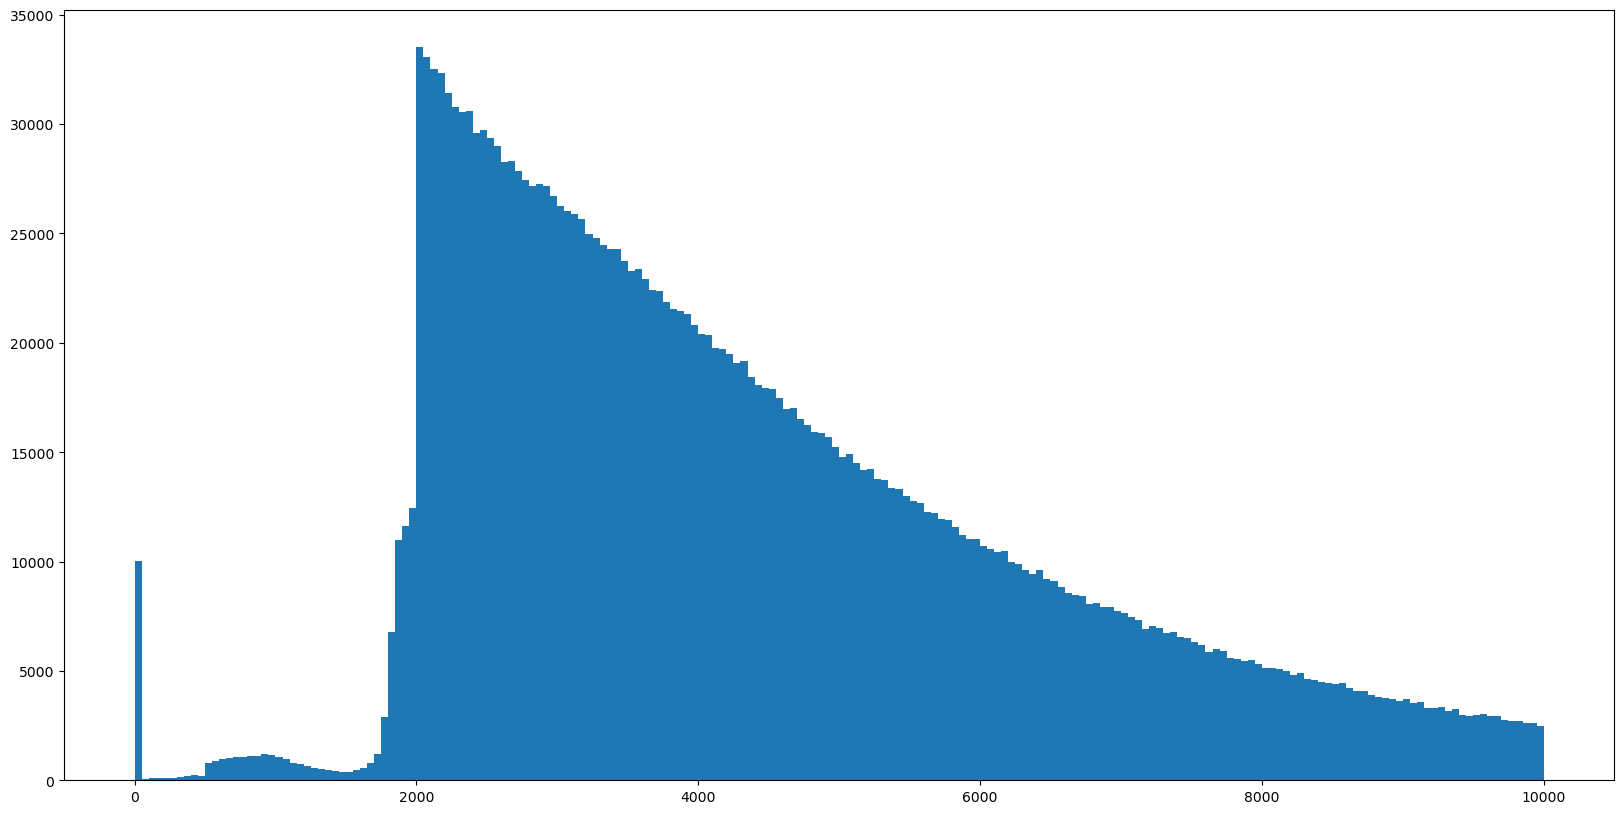

In [7]:
plt.figure(figsize=(20,10))
plt.hist(intensity['sum'], bins=200, range=[0, 10000])
plt.show()

# Snr analysis

In [8]:
# intensity.loc[intensity['snr']>20, 'snr'] = 20
# plt.figure(figsize=(20,10))
# plt.hist(intensity.loc[:, 'snr'], bins=1000)
# plt.show()

In [9]:
# plt.figure(figsize=(20,10))
# plt.hist(intensity['sum_G'], bins=200, range=[100,5000])
# plt.show()

In [10]:
# data = intensity[intensity['sum']>750]
# data = data[data['label']>15]

# label_counts = data['label'].value_counts()
# label_percentages = label_counts / label_counts.sum()

# plt.figure(figsize=(8, 8))  # 设置图形的大小
# plt.pie(label_percentages, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
# plt.axis('equal')
# plt.legend()
# plt.show()

# Save spots raw images

In [14]:
gene_list = pd.read_csv(src_dir / 'gene_list.csv')['gene'].tolist()[:30]
# PRISM_dict = {PRISM:gene.upper() for PRISM, gene in zip(sorted([f'PRISM_{i}' for i in range(1,32)]), gene_list)}
# gene_list = [PRISM_dict[f'PRISM_{i}'] for i in range(1,32)]

In [16]:
channels = {'cy5','cy3','FAM','TxRed'}
spots = {}

for gene in gene_list[:31]:
    spots[gene] = mapped_genes[mapped_genes['Gene'] == gene].sample(n=20)

# os.makedirs(check_dir / 'morethan750', exist_ok=True)
for chn in channels:
    im = imread(stc_dir / f'cyc_1_{chn}.tif')
    for gene_index, gene in enumerate(spots.keys(), start=1):
        for index, spot in spots[gene].iterrows():
            x_start = int(spot['X'])
            y_start = int(spot['Y'])
    
            im_cut = im[max(0, y_start-15): min(im.shape[0], y_start+16), 
                        max(0, x_start-15): min(im.shape[1], x_start+16)]
            imsave(check_dir / f'{gene_index}_{gene}_{index}_{chn}_crop.tif', im_cut, check_contrast=False)

In [17]:
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['text.color'] = 'white'

# Function to extract the central 10x10 region and the diagonal from it
def extract_center_and_diagonal(channel, center_size=11, position='sequence'):
    start_idx = (channel.shape[0] - center_size) // 2
    end_idx = start_idx + center_size
    center_region = channel[start_idx:end_idx, start_idx:end_idx]
    if position == 'sequence': return np.diagonal(center_region)
    elif position == 'nonsequence': return np.diagonal(np.fliplr(center_region))

def one_point(red, yellow, blue, green, axes, index, center_size=11):
    ax_im = axes[0]
    ax_imsub = axes[1]
    ax_plot = axes[2]
    ax_plot2 = axes[3]
    # Convert uint16 data to float32 to avoid overflow and for processing
    red = (red - np.mean(red)).astype(np.float32)
    yellow = (yellow - np.mean(yellow)).astype(np.float32)
    blue = (blue - np.mean(blue)).astype(np.float32)
    green = ((green - np.mean(green))*2.5).astype(np.float32)

    # Decompose the yellow channel into red and green
    red_effective = np.clip(red + 0.5 * yellow, 0, 65535)
    green_effective = np.clip(green + 0.5 * yellow, 0, 65535)
    blue_effective = np.clip(blue, 0, 65535)  # Blue channel remains unchanged
    rgb_image = np.stack((red_effective/3000, green_effective/3000, blue_effective/3000), axis=-1)
    rgb_image = np.clip(rgb_image, 0, 1)

    # Calculate the starting index
    start_index = (rgb_image.shape[0] - center_size) // 2
    end_index = start_index + center_size
    center_region = rgb_image[start_index:end_index, start_index:end_index]


    # Setup the figure and subplots
    ax_im.imshow(rgb_image)
    ax_im.set_title(index)
    ax_imsub.imshow(center_region)
    ax_imsub.set_title('Center 10x10 Region')

    # Extract diagonals
    diag_red = extract_center_and_diagonal(red, center_size=center_size)
    diag_yellow = extract_center_and_diagonal(yellow, center_size=center_size)
    diag_blue = extract_center_and_diagonal(blue, center_size=center_size)
    diag_green = extract_center_and_diagonal(green, center_size=center_size)
    ax_plot.plot(diag_red, 'r-', label='Red')
    ax_plot.plot(diag_green, 'g-', label='Green')
    ax_plot.plot(diag_blue, 'b-', label='Blue')
    ax_plot.plot(diag_yellow, 'y-', label='Yellow')
    ax_plot.set_title('Diagonal Intensity Distribution')
    ax_plot.set_xlabel('Diagonal Index')
    ax_plot.set_ylabel('Intensity')
    ax_plot.legend()

    # Extract diagonals in another position
    diag_red = extract_center_and_diagonal(red, center_size=center_size, position='nonsequence')
    diag_yellow = extract_center_and_diagonal(yellow, center_size=center_size, position='nonsequence')
    diag_blue = extract_center_and_diagonal(blue, center_size=center_size, position='nonsequence')
    diag_green = extract_center_and_diagonal(green, center_size=center_size, position='nonsequence')
    ax_plot2.plot(diag_red, 'r-', label='Red')
    ax_plot2.plot(diag_green, 'g-', label='Green')
    ax_plot2.plot(diag_blue, 'b-', label='Blue')
    ax_plot2.plot(diag_yellow, 'y-', label='Yellow')
    ax_plot2.set_title('Diagonal Intensity Distribution')
    ax_plot2.set_xlabel('Diagonal Index')
    ax_plot2.set_ylabel('Intensity')
    ax_plot2.legend()

In [18]:
for gene_index, gene in tqdm(enumerate(gene_list, start=1), total=len(gene_list), desc='Drawing_spots'):
    index_list = [_.split('_')[-3] for _ in os.listdir(check_dir) if _.split('_')[0]==f'{gene_index}']
    points = {}
    for index in index_list:
        red = imread(check_dir / f'{gene_index}_{gene}_{index}_cy5_crop.tif')
        yellow = imread(check_dir / f'{gene_index}_{gene}_{index}_TxRed_crop.tif')
        blue = imread(check_dir / f'{gene_index}_{gene}_{index}_FAM_crop.tif')
        green = imread(check_dir / f'{gene_index}_{gene}_{index}_cy3_crop.tif')
        points[index] = {'red':red, 'green':green, 'blue':blue, 'yellow':yellow}
    # points
    fig, axes = plt.subplots(ncols=4, nrows=len(points), figsize=(16, 4*len(points)))
    for i, (index, point) in enumerate(points.items()):
        red = point['red']
        green = point['green']
        blue = point['blue']
        yellow = point['yellow']
        one_point(red,yellow,blue,green,axes=axes[i,:],index=index)
    plt.tight_layout()

    plt.savefig(check_dir / f'_overall_{gene_index}.png', bbox_inches='tight', dpi=300)
    plt.close(fig)

Drawing_spots: 100%|██████████| 30/30 [07:39<00:00, 15.33s/it]


In [24]:
index = 814990
y, x = intensity.loc[index, ['Y', 'X']]
print(mapped_genes.loc[index])
intensity[(intensity['Y'] >= y - 5) & (intensity['Y'] <= y + 5) &
          (intensity['X'] >= x - 5) & (intensity['X'] <= x + 5)]

Y         1173
X        10716
Gene    ZNF683
Name: 814990, dtype: object


,Y,X,Channel,R,Ye,G,B,Scaled_R,Scaled_Ye,Scaled_G,Scaled_B,sum,G/A,sum_G
51949,1171,10713,cy5,1148,1168,0,2048.0,1148,1168,0.0,2048.0,4364.0,0.0,4364.0
814990,1173,10716,TxRed,0,1206,0,0.0,0,1206,0.0,0.0,1206.0,0.0,1206.0
828702,1169,10714,TxRed,1148,1168,0,2048.0,1148,1168,0.0,2048.0,4364.0,0.0,4364.0


# legacy

In [75]:
merged_df = pd.merge(spot, intensity, on=['Y', 'X'], how='inner')
merged_df

In [ ]:
spot['intensity'] = intensity['sum_G']

,Y,X,Gene
1221415,16340,56060,PRISM_1


In [ ]:
random = merged_df[merged_df['Gene'] == 'PRISM_1'].sample(n=1)
#random = random[random['sum_G']>4000].sample(n=1)
random

,Y,X,Gene,R,Ye,G,B,Scaled_R,Scaled_Ye,Scaled_G,Scaled_B,sum,sum_G,R/A,Ye/A,B/A,G/A,X_coor,Y_coor
12138,20129,16050,PRISM_1,2867.0,0.0,0.0,0.0,2867.0,0.0,0.0,0.0,2867.0,2867.0,1.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
Gene_list = ['PRISM_48','PRISM_54']

In [ ]:
x_start = 23167
y_start = 31839
x_width = 30
y_width = 30
channels = {'cy5','cy3','FAM','TxRed'}

for chn in channels:
    for i in range(1,2):
        im = imread(stc_dir/f'cyc_{i}_{chn}.tif')
        im = im[y_start-15:y_start+15,x_start-15:x_start+15]
        imsave(check_dir/f'cyc_{i}_{chn}_crop.tif',im)

/tmp/ipykernel_255279/833749797.py:11: UserWarning: /mnt/data/local_processed_data/20240320_Embryo_PRISM64_10um_E14.5_Test_3_processed/check/cyc_1_TxRed_crop.tif is a low contrast image
  imsave(check_dir/f'cyc_{i}_{chn}_crop.tif',im)
/tmp/ipykernel_255279/833749797.py:11: UserWarning: /mnt/data/local_processed_data/20240320_Embryo_PRISM64_10um_E14.5_Test_3_processed/check/cyc_1_cy5_crop.tif is a low contrast image
  imsave(check_dir/f'cyc_{i}_{chn}_crop.tif',im)
/tmp/ipykernel_255279/833749797.py:11: UserWarning: /mnt/data/local_processed_data/20240320_Embryo_PRISM64_10um_E14.5_Test_3_processed/check/cyc_1_FAM_crop.tif is a low contrast image
  imsave(check_dir/f'cyc_{i}_{chn}_crop.tif',im)
/tmp/ipykernel_255279/833749797.py:11: UserWarning: /mnt/data/local_processed_data/20240320_Embryo_PRISM64_10um_E14.5_Test_3_processed/check/cyc_1_cy3_crop.tif is a low contrast image
  imsave(check_dir/f'cyc_{i}_{chn}_crop.tif',im)


In [ ]:
seq_old = pd.read_csv(read_old_dir/'ref_checked.csv')
seq_new = pd.read_csv(read_new_dir/'ref_checked.csv')

In [ ]:
seq_old[(seq_old['X']==52600)&(seq_old['Y']==25565)]

,Unnamed: 0,Y,X,Sequence
9246016,25994923,25565,52600,GGCCGGCGCG


In [ ]:
seq_new[(seq_new['X']==52600)&(seq_new['Y']==25565)]

,Unnamed: 0,Y,X,Sequence
13007229,20146625,25565,52600,CGCCGGCTAG


In [ ]:
Actb_new

,Y,X,Gene
30,147,24340,Actb
110,175,24451,Actb
120,179,24316,Actb
171,184,24736,Actb
269,192,24964,Actb
...,...,...,...
23987973,46789,29093,Actb
23987974,46792,29086,Actb
23987976,46793,29043,Actb
23987978,46793,29265,Actb


In [ ]:
import scanpy as sc
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
import matplotlib.gridspec as gridspec
import pickle

# Preprocessing
def adata_filter(adata, min_genes, min_counts, max_counts, min_cells):
    sc.pp.filter_cells(adata, min_genes=min_genes)
    sc.pp.filter_cells(adata, min_counts=min_counts)
    sc.pp.filter_cells(adata, max_counts=max_counts)
    sc.pp.filter_genes(adata, min_cells=min_cells)
    return adata


def QC_plot(adata, hue, min_counts='nan', max_counts='nan', min_genes='nan', min_cells='nan'):
    g = sns.JointGrid(
        data=adata.obs,
        #x="total_counts",
        #y="n_genes_by_counts",
        height=5,
        ratio=2,
        hue=hue,
    )
    
    g.plot_joint(sns.scatterplot, s=40, alpha=0.3)
    g.plot_marginals(sns.kdeplot)
    g.set_axis_labels("total_counts", "n_genes_by_counts", fontsize=16)
    g.fig.set_figwidth(6)
    g.fig.set_figheight(6)
    g.fig.suptitle("QC_by_{}, cell_num={}, gene_num={}\n\
                   min_counts={}, max_counts={}, min_genes={}, min_cells={}\
                   \n\n\n\n\n".format(hue,len(adata),len(adata.var.index),min_counts, max_counts, min_genes, min_cells))
    plt.show()


def general_preprocess(adata, min_genes=2, min_counts=5, max_counts=200, min_cells=3, auto_filter=False, hue='dataset'):
    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True)

    fig = plt.figure(figsize=(12, 4))  # You can adjust the overall figure size here
    gs = gridspec.GridSpec(1, 3)
    # Plot top 20 most expressed genes
    ax1 = fig.add_subplot(gs[0, 0])
    sc.pl.highest_expr_genes(adata, n_top=10, ax=ax1, show=False)
    # distribution of cell counts
    ax2 = fig.add_subplot(gs[0, 1:3])
    counts = adata.obs.total_counts
    sns.histplot(counts, stat='count', ax=ax2,
                bins=150, edgecolor='white', linewidth=0.5, alpha=1, 
                kde=True, line_kws=dict(color='black', alpha=0.7, linewidth=1.5, label='KDE'), kde_kws={'bw_adjust': 1},
                )
    y = ax2.get_lines()[0].get_ydata()
    maxima = [float(_/len(y)*(max(counts)-min(counts))+min(counts)) for _ in argrelextrema(-np.array(y), np.less)[0]]
    print(f'maxima: {maxima}')
    plt.tight_layout()
    plt.show()
    plt.close(fig=fig)

    
    
    # plot origin and filtered in a combined figure
    fig = plt.figure(figsize=(12, 6))
    gs = gridspec.GridSpec(3, 6)
    categories = adata.obs[hue].unique()

    ax_1_scatter = fig.add_subplot(gs[1:3, 0:2])
    sns.scatterplot(x=adata.obs.total_counts, y=adata.obs.n_genes_by_counts,
                    hue=adata.obs[hue], ax=ax_1_scatter, )
    
    ax_1_count = fig.add_subplot(gs[0:1, 0:2])
    for category in categories:
        subset = adata[adata.obs[hue] == category]
        sns.kdeplot(subset.obs.total_counts, ax=ax_1_count)
    ax_1_count.xaxis.set_visible(False)
    ax_1_count.yaxis.set_visible(False)
    ax_1_count.grid(False)

    ax_1_gene = fig.add_subplot(gs[1:3, 2:3])
    for category in categories:
        subset = adata[adata.obs[hue] == category]
        sns.kdeplot(y=subset.obs.n_genes_by_counts, ax=ax_1_gene)
    ax_1_gene.xaxis.set_visible(False)
    ax_1_gene.yaxis.set_visible(False)
    ax_1_gene.grid(False)

    ax_1_count.set_title("QC_by_{}, cell_num={}, gene_num={}\n\
                         min_counts={}, max_counts={}, \n\
                         min_genes={}, min_cells={}\
                         ".format(hue, len(adata), len(adata.var.index), 'nan', 'nan', 'nan', 'nan'))

    origin_cell_num = len(adata)
    min_counts = int(maxima[0]) if auto_filter else min_counts
    max_counts = int(np.percentile(counts, 99.9)) if auto_filter else max_counts
    adata = adata_filter(adata, min_genes, min_counts, max_counts, min_cells)
    filtered_cell_num = len(adata)

    ax_2_scatter = fig.add_subplot(gs[1:3, 3:5])
    sns.scatterplot(x=adata.obs.total_counts, y=adata.obs.n_genes_by_counts,
                    hue=adata.obs[hue], ax=ax_2_scatter, )
    
    ax_2_count = fig.add_subplot(gs[0:1, 3:5])
    categories = adata.obs[hue].unique()
    for category in categories:
        subset = adata[adata.obs[hue] == category]
        sns.kdeplot(subset.obs.total_counts, ax=ax_2_count)
    ax_2_count.xaxis.set_visible(False)
    ax_2_count.yaxis.set_visible(False)
    ax_2_count.grid(False)

    ax_2_gene = fig.add_subplot(gs[1:3, 5:6])
    for category in categories:
        subset = adata[adata.obs[hue] == category]
        sns.kdeplot(y=subset.obs.n_genes_by_counts, ax=ax_2_gene)
    ax_2_gene.xaxis.set_visible(False)
    ax_2_gene.yaxis.set_visible(False)
    ax_2_gene.grid(False)

    ax_2_count.set_title("QC_by_{}, cell_num={}, gene_num={}\n\
                         min_counts={}, max_counts={}, \n\
                         min_genes={}, min_cells={}\
                         ".format(hue, len(adata), len(adata.var.index), min_counts, max_counts, min_genes, min_cells))
    
    plt.tight_layout()
    
    plt.show()
    plt.close(fig=fig)

    # plot origin

    # QC_plot(adata, hue='dataset')

    # # plot filtered
    # min_counts = int(maxima[0]) if auto_filter else min_counts
    # max_counts = int(np.percentile(counts, 99.9)) if auto_filter else max_counts
    # adata = adata_filter(adata, min_genes, min_counts, max_counts, min_cells)
    # filtered_cell_num = len(adata)
    # QC_plot(adata, hue='dataset', min_genes=min_genes, min_counts=min_counts, max_counts=max_counts, min_cells=min_cells)
    return adata, origin_cell_num, filtered_cell_num


# g = sns.JointGrid(
#     data=adata.obs,
#     x="total_counts",
#     y="n_genes_by_counts",
#     height=5,
#     ratio=2,
#     hue=hue,
# )

# g.plot_joint(sns.scatterplot, s=40, alpha=0.3)
# g.plot_marginals(sns.kdeplot)
# g.set_axis_labels("total_counts", "n_genes_by_counts", fontsize=16)
# g.fig.set_figwidth(6)
# g.fig.set_figheight(6)
# g.fig.suptitle("QC_by_{}, cell_num={}, gene_num={}\n\
#                 min_counts={}, max_counts={}, min_genes={}, min_cells={}\
#                 \n\n\n\n\n".format(hue,len(adata),len(adata.var.index),min_counts, max_counts, min_genes, min_cells))
# plt.show()


def preprocess_of_UMAP(adata):
    # Normalization scaling
    sc.pp.normalize_total(adata)
    #sc.pp.log1p(adata)
    # Scale data to unit variance and zero mean
    #sc.pp.regress_out(adata, ["total_counts"])
    sc.pp.scale(adata)
    return adata


def save_pos_on_UMAP(adata, out_dir):
    try:
        adata_coor = pd.DataFrame(
            adata.obsm["X_umap"], columns=["Coor_X", "Coor_Y"], index=adata.obs.index
        )
        df = pd.concat(
            [
                adata_coor["Coor_X"],
                adata_coor["Coor_Y"],
                pd.DataFrame(adata.obs.index),
                adata.obs.leiden,
            ],
            axis=1,
        )
        df.to_csv(out_dir)
    except KeyError:
        print('X_umap not found, please perform umap first.')


def save_cell_cluster(
    adata,
    out_path,
    st_point,
    cell_num,
    name="leiden",
):
    raw_clu = dict(adata.obs[name])
    cluster = dict()
    for cell_num in raw_clu.keys():
        cluster[cell_num] = -1

    for cell in raw_clu.keys():
        cluster[int(cell) - st_point] = int(raw_clu[cell])

    with open(out_path, "wb") as handle:
        pickle.dump(cluster, handle)


def UMAP_genes_plot(adata, FOI='', size=0.1, save=False, out_path='./', datatype='direct', dataset=[],gene_list=['Slc17a7','Gad1','Gad2','Snap25']):
    n_pcs = len(adata.uns['pca']['variance'])
    n_neighbors = adata.uns['neighbors']['params']['n_neighbors']
    resolution = adata.uns['leiden']['params']['resolution']
    # Plot Gene distribution
    ncols = int(-(-len(gene_list)**(1/2)//1))
    nrows = -(-len(gene_list)//ncols)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))
    for pos, gene_name in enumerate(gene_list):
        sc.pl.umap(
            adata[adata.obs.dataset.isin(dataset)],
            size=size,
            color=gene_name,
            legend_fontweight=100,
            legend_fontsize=20,
            ax=ax[pos // ncols][pos % ncols],
            show=False,
            vmax=5,
            vmin=0,
            cmap='inferno_r'
        )
        ax[pos // ncols][pos % ncols].set_xticklabels("")
        ax[pos // ncols][pos % ncols].set_yticklabels("")

    fig.suptitle(
        "{}\nexp:{}\nUMAP:{}\n".format(
        f"{FOI}_{datatype}_{dataset}_UMAP",
        f"cell_num={len(adata)}",
        f"n_neighbors={n_neighbors}, n_pcs={n_pcs}, resolution={resolution}"),
        fontsize=20,
    )
    plt.tight_layout()

    if save:
        plt.savefig(f"{out_path}/{FOI}_{datatype}_UMAP_genes.png")
        plt.close()
    else:
        plt.show()


def UMAP_leiden_plot(adata, FOI='', color='leiden', save=False, out_path='./',dpi=300, datatype='direct', DOI=['PRISM3D'], legend_loc='on data', palette=False, size=1):
    n_pcs = len(adata.uns['pca']['variance'])
    n_neighbors = adata.uns['neighbors']['params']['n_neighbors']
    resolution = adata.uns['leiden']['params']['resolution']
    # Plot Cluster
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    
    if palette:
        sc.pl.umap(
            adata[adata.obs.dataset.isin(DOI)],
            size=size, color=color, palette=palette, 
            legend_loc=legend_loc, legend_fontsize=7,
            ax=ax[0], show=False,
        )

        sc.pl.umap(
            adata,
            size=size, color="dataset",
            legend_fontweight=100, legend_fontsize=20,
            ax=ax[1], show=False,
        )
    else:
        sc.pl.umap(
            adata[adata.obs.dataset.isin(DOI)],
            size=size, color=color,
            legend_loc=legend_loc, legend_fontsize=7,
            ax=ax[0], show=False,
        )

        sc.pl.umap(
            adata,
            size=size, color="dataset",
            legend_fontweight=100, legend_fontsize=20,
            ax=ax[1], show=False,
        )
    fig.suptitle(
        "{}\nexp:{}\nUMAP:{}\n".format(
        f"{FOI}_{datatype}_cluster",
        f"cell_num={len(adata)}",
        f"n_neighbors={n_neighbors}, n_pcs={n_pcs}, resolution={resolution}"),
        fontsize=20,
    )
    plt.tight_layout()
    if save:
        if out_path.endswith('.png'):    
            plt.savefig(f"{out_path}", bbox_inches = 'tight', dpi=dpi)
        else:
            plt.savefig(f"{out_path}", bbox_inches = 'tight')
        plt.close()
    else:
        plt.show()


def leiden_QC_plot(adata, color='leiden'):
    # cluster QC
    g = sns.JointGrid(
        data=adata.obs,
        x="total_counts",
        y="n_genes_by_counts",
        height=5,
        ratio=2,
        hue=color,
    )
    g.plot_joint(sns.scatterplot, s=40, alpha=0.3)
    g.plot_marginals(sns.kdeplot)
    g.set_axis_labels("total_counts", "n_genes_by_counts", fontsize=8)
    g.fig.set_figwidth(3)
    g.fig.set_figheight(3)
    plt.show()

In [ ]:
def threshold_in_cluster(adata, marker_gene=[], thre_gene=['AFP','GPC3','ACTA2','PECAM1'], type_name=[], cluster_dict={}):
# for cluster_gene in cluster_to_filter:
    thre_min = [True] * len(marker_gene) + [False] * len(thre_gene)
    gene_list = marker_gene + thre_gene
    minima_dict = {}
    for _ in gene_list:
        minima_dict[_] = ''

    cluster_list_temp=[]
    for _ in cluster_dict.keys():
        for name in type_name:
            if name in _:
                cluster_list_temp += [str(_) for _ in cluster_dict[_]]

    cluster = adata[adata.obs.leiden.isin(cluster_list_temp)]

    fig, ax = plt.subplots(nrows=1,ncols=len(thre_min),figsize=(24, 4))
    for i, gene in enumerate(gene_list):
        a = [float(_) for _ in cluster[:, gene].X]
        sns.histplot(a, bins=20, stat='density', alpha= 1, kde=True,
                    edgecolor='white', linewidth=0.5,
                    log=True, 
                    ax=ax[i],
                    line_kws=dict(color='black', alpha=0.7, linewidth=1.5, label='KDE'))
        ax[i].get_lines()[0].set_color('red') # edit line color due to bug in sns v 0.11.0
        ax[i].set_xlabel(gene)

        y = ax[i].get_lines()[0].get_ydata()
        minima_dict[gene] = [float(_/len(y)*(max(a)-min(a))+min(a)) for _ in argrelextrema(np.array(y), np.less)[0]]
        # print(f'{gene}_minima: {minima_dict[gene]}')
        fig.subplots_adjust(hspace=0.4)
        fig.subplots_adjust(wspace=0.4)
        fig.suptitle(f'distribution of cluster, marker gene={marker_gene}')
    plt.show()

    cluster.obs['tmp_leiden'] = ['-1']*len(cluster)
    for _, gene in enumerate(gene_list):
        minima = minima_dict[gene]
        while True:
            if len(minima) == 0:
                minima = [0]
                break
            if minima[0] > 1 and gene != 'CPA3':
                minima[0] = 0
                break
            if minima[0] < -1 and gene != 'CPA3':
                minima.pop(0)
                continue
            break
        
        print(f'{gene}_thre: {minima[0]}')

        if thre_min[_]:
            tmp = cluster[cluster[:, gene].X > minima[0]]
            cluster.obs['tmp_leiden'][tmp.obs.index] = ['1']*len(tmp)
        else:
            tmp = cluster[cluster[:, gene].X > minima[0]]
            cluster.obs['tmp_leiden'][tmp.obs.index] = ['-1']*len(tmp)
    
    tmp = cluster[cluster.obs['tmp_leiden']=='-1']
    adata.obs['tmp_leiden'][tmp.obs.index] = ['-2']*len(tmp)

    cell_to_plot = len(cluster[cluster.obs['tmp_leiden']=='1'])
    print(f'marker_gene={marker_gene}, {cell_to_plot} cells of {len(cluster)} cells left\n')
    return adata


def collect_liver(combine_adata_st, tissue_obs='tissue', in_out_leiden='tmp_leiden'):
    other_cluster = combine_adata_st[combine_adata_st.obs[in_out_leiden]=='-2']
    liver = other_cluster[other_cluster.obs[tissue_obs] == "liver"]
    combine_adata_st.obs[in_out_leiden] = list(combine_adata_st.obs[in_out_leiden])
    combine_adata_st.obs[in_out_leiden][liver.obs.index] = ["-1"] * len(liver)
    return combine_adata_st

In [ ]:
matrix_1 = pd.read_csv(read_dir/'matrix_Hdc+_3.csv')
matrix_1 = matrix_1.transpose()
matrix_1.columns = matrix_1.iloc[0]
matrix_1 = matrix_1[1:]
matrix_1

gene_symbol,Xkr4,Gm1992,Gm19938,Gm37381,Rp1,Sox17,Gm37587,Gm37323,Mrpl15,Lypla1,...,Gm16367,AC163611.1,AC163611.2,AC140365.1,AC124606.2,AC124606.1,AC133095.2,AC133095.1,AC234645.1,AC149090.1
235,9.485123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
467,9.035719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.244763,6.244763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.23522
528,8.447866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.447866
529,9.789675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.625444
1136,9.615854,6.628668,0.0,0.0,6.628668,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93351,8.177505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.194193


In [ ]:
# load expression matrix
adata = sc.AnnData(matrix_1)
adata.var.index = adata.var.index.str.upper()
adata.obs['dataset'] = ["PRISM3D"] * len(adata)
adata.raw = adata

/home/spatial/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


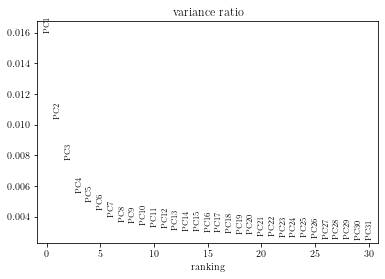

In [ ]:
# preprocess of UMAP
adata = preprocess_of_UMAP(adata)

# compute pca
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, log=False)

In [ ]:
# select the num of pc
n_pcs=20
sc.tl.pca(adata, n_comps=n_pcs)  

In [ ]:
# Run UMAP
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=n_pcs)
sc.tl.umap(adata)

In [ ]:
# Run Leiden cluster
sc.tl.leiden(adata, resolution=1)

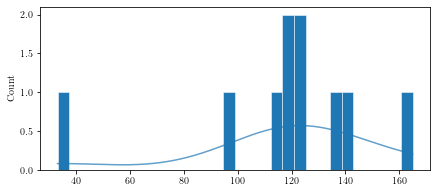

In [ ]:
a = [len(adata[adata.obs.leiden == _]) for _ in adata.obs.leiden.unique()]
fig, ax = plt.subplots(figsize=(7,3))
sns.histplot(a, bins=30, stat='count', alpha=1, kde=True,
            edgecolor='white', linewidth=0.5,
            # log=True, 
            ax=ax,
            line_kws=dict(color='black', alpha=0.7, linewidth=1.5, label='KDE'),
            # binrange=[0,100]
            )
plt.show()

adata_thre = adata[adata.obs.leiden.isin([_ for _ in adata.obs.leiden.unique() if len(adata[adata.obs.leiden == _]) > 100])]

/home/spatial/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/spatial/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/spatial/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


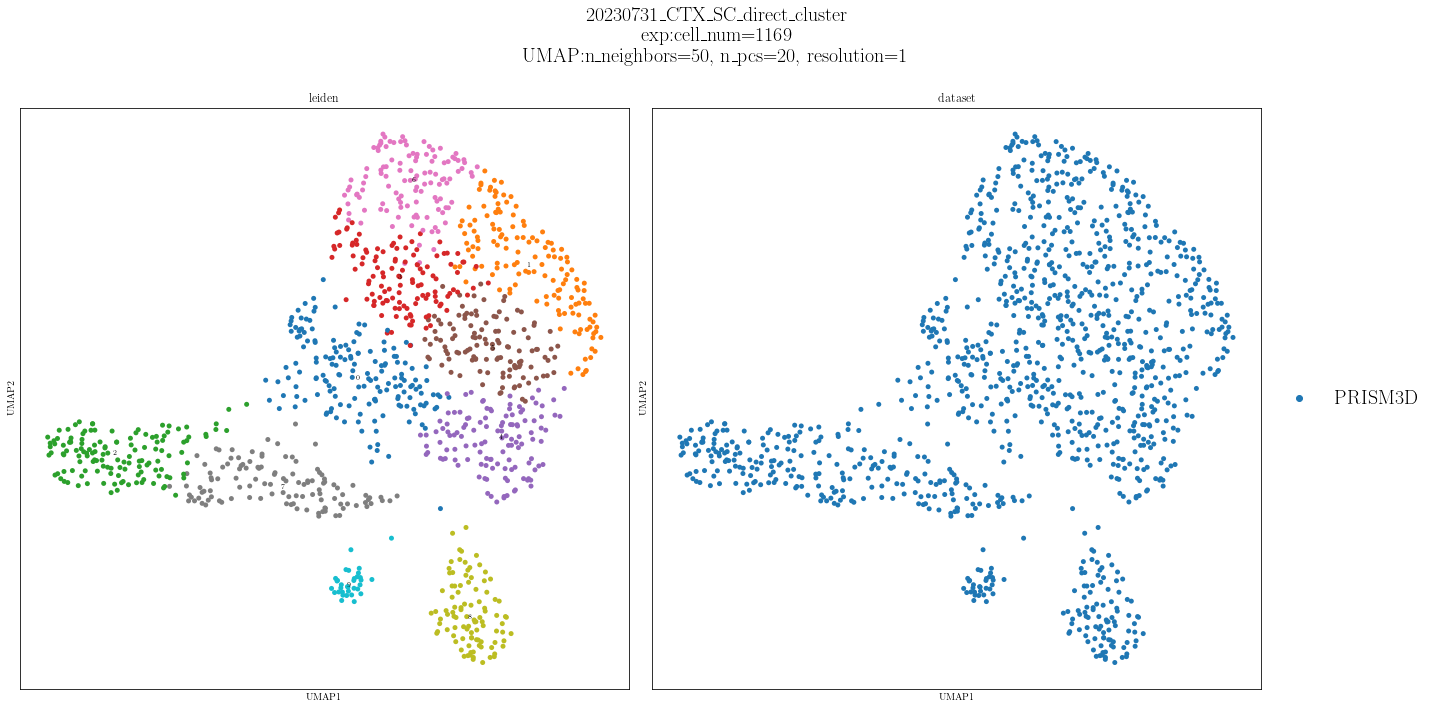

ValueError: The following variable cannot be assigned with wide-form data: `hue`

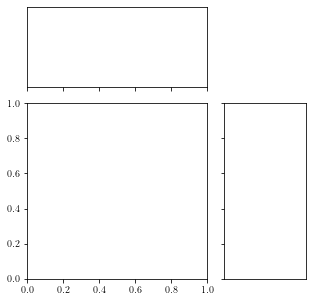

In [ ]:
UMAP_leiden_plot(adata, FOI=os.path.split(src_dir)[-1], color='leiden', save=False, out_path='', datatype='direct',size=100)
QC_plot(adata, hue='leiden')

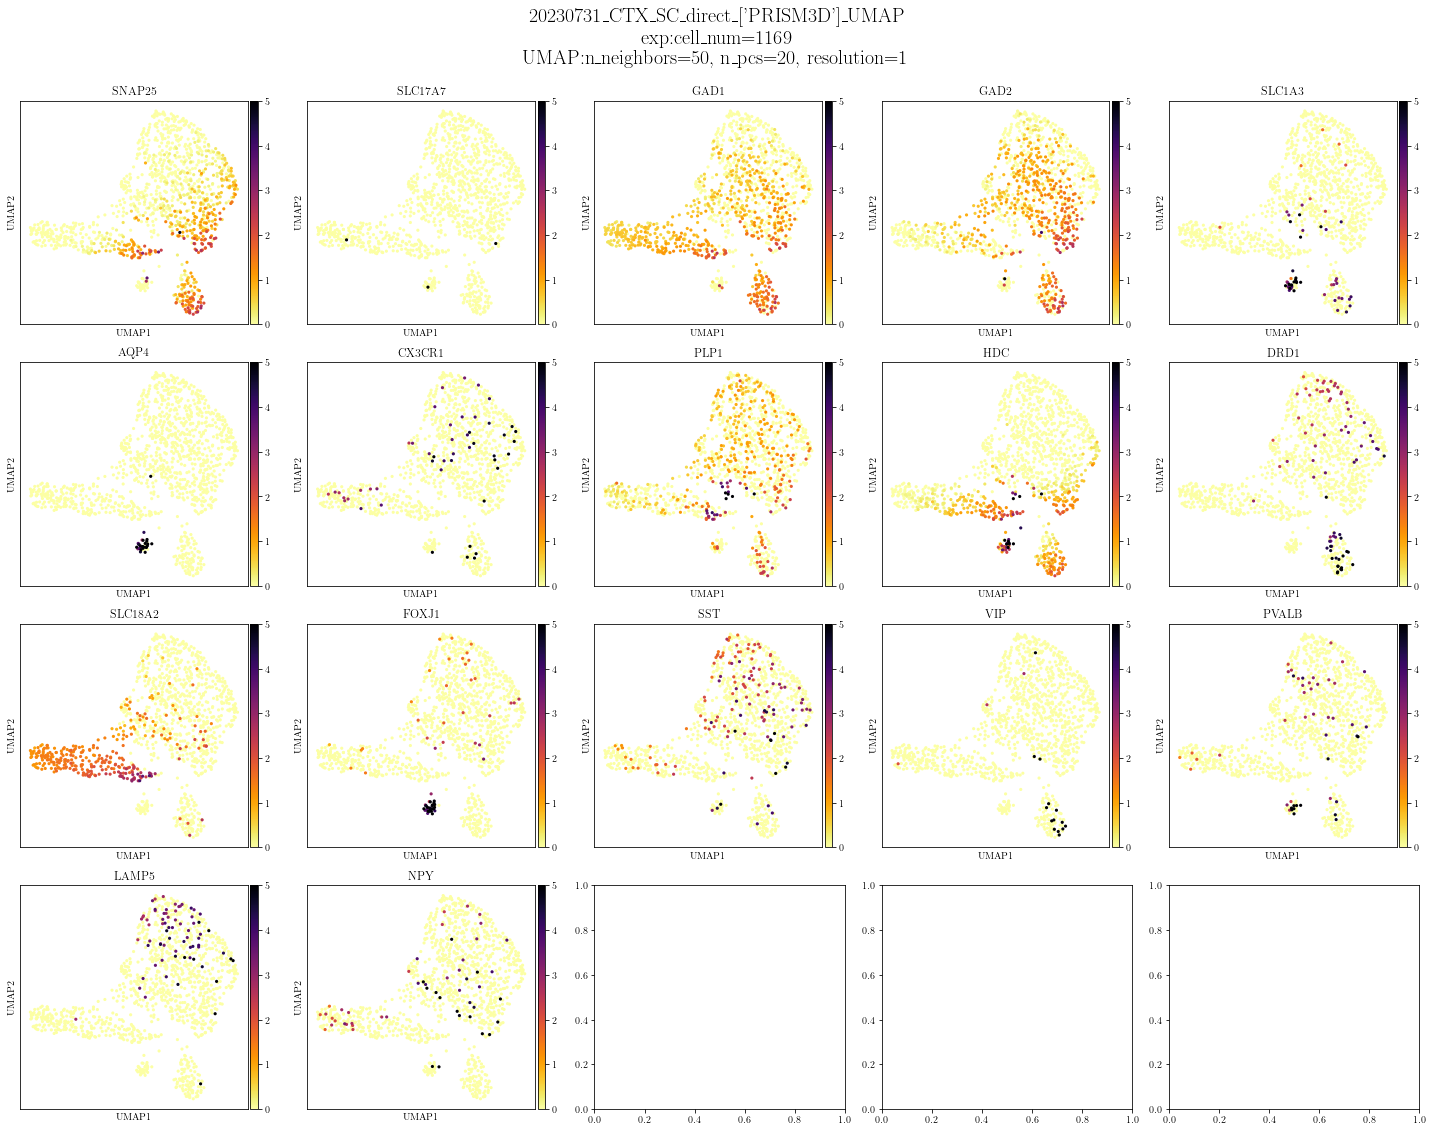

In [ ]:
UMAP_genes_plot(adata, FOI=os.path.split(src_dir)[-1], save=False, datatype='direct', dataset=["PRISM3D"], size=40, gene_list = ['SNAP25','SLC17A7','GAD1','GAD2','SLC1A3','AQP4','CX3CR1','PLP1','HDC','DRD1','SLC18A2','FOXJ1','SST','VIP','PVALB','LAMP5','NPY'])


In [ ]:
adata.var_names

Index(['XKR4', 'GM1992', 'GM19938', 'GM37381', 'RP1', 'SOX17', 'GM37587',
       'GM37323', 'MRPL15', 'LYPLA1',
       ...
       'GM16367', 'AC163611.1', 'AC163611.2', 'AC140365.1', 'AC124606.2',
       'AC124606.1', 'AC133095.2', 'AC133095.1', 'AC234645.1', 'AC149090.1'],
      dtype='object', name='gene_symbol', length=32285)

In [ ]:
adata.var_names[adata.var_names=='SNAP25']

Index(['SNAP25'], dtype='object', name='gene_symbol')